In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from tyssue.generation import generate_ring
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.config.draw import sheet_spec

from tyssue_taylor.adjusters.adjust_annular import prepare_tensions, adjust_parameters
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, opt_sum_lambda
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)
from tyssue_taylor.adjusters.cost_functions import distance_regularized

Using TensorFlow backend.


#### Initialisation d'un maillage régulier 

Reseting datasets values with new specs


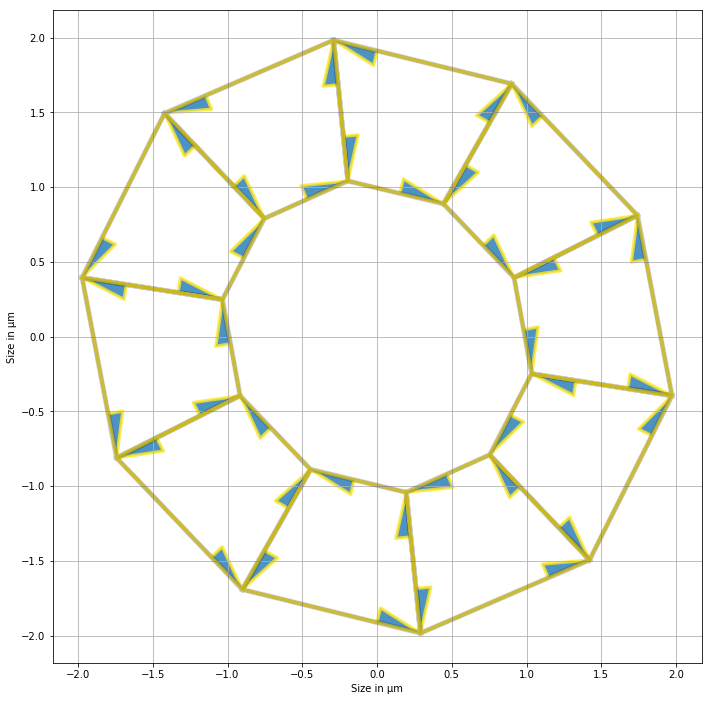

In [2]:
nf, r_in, r_out = (10, 1, 2)
seed = 1
organo = create_organo(nf, r_in, r_out, rot=np.pi/12)

geom.update_all(organo)
solver.find_energy_min(organo, geom, model)
print_tensions(organo, organo)

Le module cost_functions contient la fonction coût de la procédure de recalage et de la fonction opt_sum_lambda du module force_inference. En général, les fonctions du module cost_functions n'ont pas vocation à être appelées par l'utilisateur final, sauf si celui-ci souhaite connaître la distance entre deux organoïdes en fonction de leur paramètres physiques.

Il peut alors appeler la fonction distance_regularized. Cette fonction prend en paramètres:

- eptm: un maillage de class AnnularSheet représentant le maillage expérimental.
- objective_eptm: un maillage de class AnnularSheet représentant le maillage théorique.
- variables: le tableau des paramètres de l'organoïde expérimental, obtenu après l'appel de la fonction adjusters.adjust_annular._prepare_params.
- kwargs: les paramètres d'optimisation pour le L-BFGS-B de la minimisation de l'énergie

Et comme paramètres optionnels:

- solver: objet de class tyssue.solvers.sheet_vertex_solver
- geom: objet de class AnnularGeometry importé depuis tyssue_taylor.models.annular
- model: importé depuis tyssue_taylor.models.annular
- coords: defaut = None, les coordonnées auxquelles calculer la distance, si None, fixées à eptm.coords
- IPRINT: defaut = None, un fichier dans lequel écrire le résultat du calcul de la distance, si None aucun fichier n'est écrit.
- COPY_OR_SYM: default = 'copy'. Détermine si l'organoïde expérimental est initialiser comme une copie de l'organoïde théorique ('copy') ou comme un organoïde régulier ('sym').

Tout d'abord on importe _prepare_params et on initialise les paramètres nécéssaires pour distance_regularized. 

In [3]:
from tyssue_taylor.adjusters.adjust_annular import _prepare_params

eptm = organo.copy()


t_table = 0.01*np.ones(3*eptm.Nf)
a_table = 1.1*organo.face_df.prefered_area.values
l_vol = 1.1*organo.settings['lumen_prefered_vol']

splitted_var = [t_table, a_table, l_vol]

parameters=[('edge', 'line_tension'), ('face', 'prefered_area')]

variables = _prepare_params(eptm, splitted_var, parameters)

energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}

On voit que l'appel de distance_regularized nécéssite beaucoup de manipulation.

In [4]:
dist = distance_regularized(eptm,
                            organo,
                            variables,
                            solver, geom, model,
                            coords=None,
                            IPRINT=None,
                            COPY_OR_SYM='copy',
                            **energy_opt)

distance_regularized calcule les résidus pour chacun des points du maillage et un terme de pénalisation si les tensions sont négatives. Pour afficher la distance entre les deux organoïdes, il faut donc sommer ces résidus.

In [5]:
print(dist.sum())

2.3974294486707883
